<a href="https://colab.research.google.com/github/iamviji/project/blob/master/golden-copy/Arch1_Arch2_Arch3-V_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy 
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()
import matplotlib.pyplot as plt


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
NUM_OF_INPUT_MESSAGE = 1000

In [3]:
# Helper Function
def bits2int(a, axis=-1):
    return numpy.right_shift(numpy.packbits(a, axis=axis), 8 - a.shape[axis]).squeeze()


def row_bits2int(arr):
    n = arr.shape[1]  # number of columns
    # shift the bits of the first column to the left by n - 1
    a = arr[:, 0] << n - 1  

    for j in range(1, n):
        # "overlay" with the shifted bits of the next column
        a |= arr[:, j] << n - 1 - j  
    return a

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

In [22]:
# PSK-4 (Primitive)(QPSK)
channel_size = 1
input_message_length = 2
num_hidden_1 = 2 * channel_size 
print ("input_message_length=", input_message_length, "channel_size", channel_size)

input_message_x = tf.placeholder("float32", [None, input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, 2 * channel_size], name="input_channel_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length, input_message_length], -1, 1), name="encoder_l1_weights"),
  "encoder_l2" : tf.Variable (tf.random_uniform([input_message_length, num_hidden_1], -1, 1), name="encoder_l2_weights"),

  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1, input_message_length], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length, input_message_length], -1, 1), name="decoder_l2_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="encoder_l1_bias"),
  "encoder_l2" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l2_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l2_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  layer_2 = tf.nn.tanh (tf.matmul(layer_1, weights['encoder_l2']) + biases['encoder_l2'])
  #layer_2 = tf.round(layer_1)
  layer_3 =  layer_2 / tf.sqrt(tf.reduce_mean(tf.square(layer_2)))
  #layer_2 =  tf.nn.relu(layer_1)
  return layer_3

def dl_decoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = tf.nn.sigmoid (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  return layer_2

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)


loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))
lr = tf.placeholder(dtype=tf.float32,shape=[])
opt = tf.train.AdamOptimizer(learning_rate=lr).minimize (loss1)


awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [2*channel_size])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)


input_message_length= 2 channel_size 1


In [23]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

[[1 1]
 [1 1]
 [1 0]
 ...
 [1 0]
 [0 0]
 [0 0]]
10000


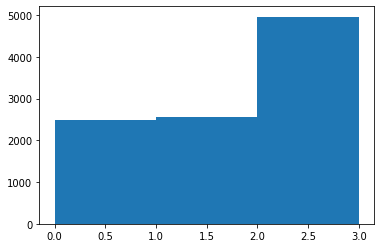

In [24]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
training_input_message_decimal = row_bits2int(training_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
y_axis = row_bits2int(training_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(training_input_message_decimal, bins = x_axis) 
plt.show()

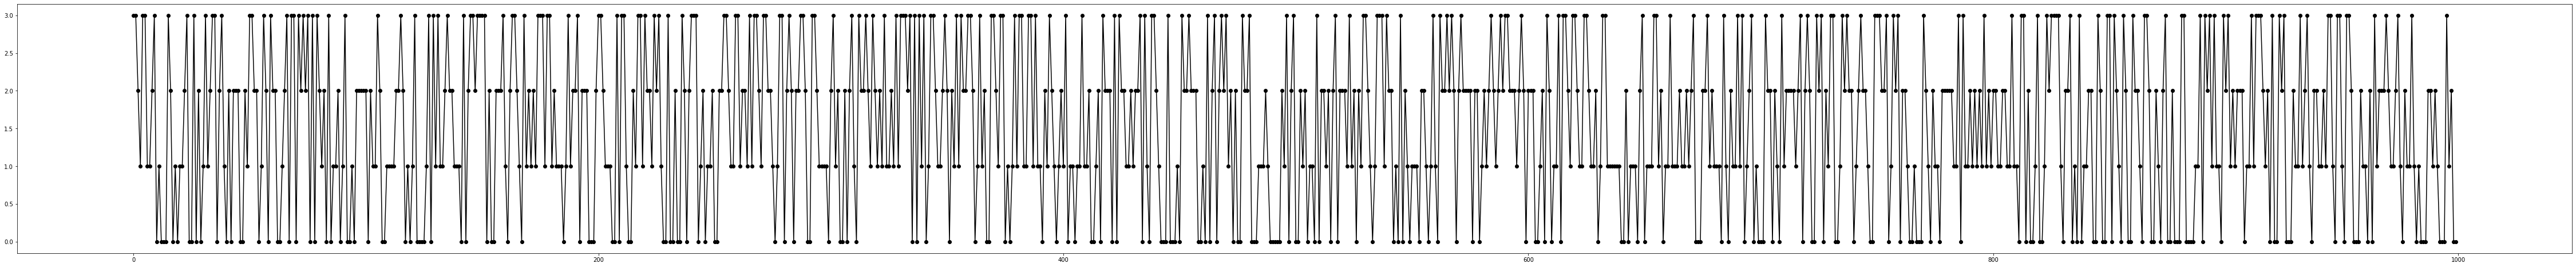

In [25]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE*10)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:NUM_OF_INPUT_MESSAGE],training_input_message_decimal[:NUM_OF_INPUT_MESSAGE], '-ok')

In [53]:
batch_size = 400


# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 60
outer_ephocs = 1
num_of_batches = len(training_input_message) / batch_size
display_step = 400
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = 0.1
i = 0
for oe in range(outer_ephocs):
  for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
    sigma = 1.0*Snr2Sigma (snr)
    print ("Training for SNR=", snr, " sigma=", sigma) 
    for e in range(epochs):
      for j in range (int(num_of_batches)):
        i = i + 1
        k = e * epochs + j
        x_train_batch = training_input_message [j*batch_size:(j+1)*batch_size]
        x_train_batch_float = x_train_batch.astype("float32")
        _, l = train_sess.run ([opt, loss1], feed_dict={input_message_x:x_train_batch_float, awgn_noise_std_dev_x:sigma, lr:lrate})
        if (l < 0.5): lrate = 0.001
        if (l < 0.25): lrate = 0.0001
        if (l < 0.1): lrate = 0.0001
        if k % display_step == 0:
          print('Step %i: Minibatch Loss: %f' % (i, l))

batch_size: 400 num_of_batcches: 25.0
Training for SNR= 0.0  sigma= 1.0
Step 1: Minibatch Loss: 1.084360
Step 161: Minibatch Loss: 0.484106
Step 321: Minibatch Loss: 0.474148
Step 1081: Minibatch Loss: 0.451649
Step 1241: Minibatch Loss: 0.440701
Training for SNR= 0.5  sigma= 0.9440608762859234
Step 1626: Minibatch Loss: 0.431061
Step 1786: Minibatch Loss: 0.411180
Step 1946: Minibatch Loss: 0.410857
Step 2706: Minibatch Loss: 0.390197
Step 2866: Minibatch Loss: 0.396426
Training for SNR= 1.0  sigma= 0.8912509381337456
Step 3251: Minibatch Loss: 0.370238
Step 3411: Minibatch Loss: 0.368840
Step 3571: Minibatch Loss: 0.363176
Step 4331: Minibatch Loss: 0.362349
Step 4491: Minibatch Loss: 0.366994
Training for SNR= 1.5  sigma= 0.8413951416451951
Step 4876: Minibatch Loss: 0.336323
Step 5036: Minibatch Loss: 0.343064
Step 5196: Minibatch Loss: 0.337737
Step 5956: Minibatch Loss: 0.348236
Step 6116: Minibatch Loss: 0.349611
Training for SNR= 2.0  sigma= 0.7943282347242815
Step 6501: Miniba

In [39]:
# Here I am using trained model
NUM_OF_INPUT_MESSAGE_BER = NUM_OF_INPUT_MESSAGE * 2
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

channel_x = []
channel_y = []
channel_n_x = []
channel_n_y = []

for snr in numpy.arange (0, 10, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE_BER):
    input_message_xx = training_input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    channel_x.append(encoded_message[0][0][0])
    channel_y.append(encoded_message[0][0][1])
    #print (encoded_message[0][0])
    awgn_channel_output_message = train_sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    channel_n_x.append(awgn_channel_output_message[0][0])
    channel_n_y.append(awgn_channel_output_message[0][1])
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-training_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE_BER
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.29s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.54s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.80s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.05s
SNR: 0.000 - Iter: 1250 - Last 250.0 iterations took 1.30s
SNR: 0.000 - Iter: 1500 - Last 250.0 iterations took 1.56s
SNR: 0.000 - Iter: 1750 - Last 250.0 iterations took 1.82s
SNR: 0.000 - Iter: 2000 - Last 250.0 iterations took 2.07s
SNR: 0.000:
 -> BER: 0.28
 -> Total Time: 9.42s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.25s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.50s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.77s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.03s
SNR: 0.500 - Iter: 1250 - Last 250.0 iterations took 1.29s
SNR: 0.500 - Iter: 1500 - Last 250.0 iterations took 1.56s
SNR: 0.500 - Iter: 1750 - Last 250.0 iterations took 1.83s
SNR: 0.500 - Iter: 2000 - Last 250.0 iterations took 2.08s
SNR: 0.500:
 -

In [40]:
bler_per_iter_uncoded_commpy_psk_2= [0.521, 0.473, 0.436, 0.37,  0.304, 0.259, 0.187, 0.138, 0.098, 0.098, 0.052, 0.028, 0.012, 0.011, 0.009, 0.002, 0.0,  0.001, 0.,    0.0]
bler_per_iter_uncoded_itpp_psk_2= [0.518, 0.478, 0.415, 0.355, 0.305, 0.227, 0.177, 0.149, 0.11,  0.075, 0.055, 0.023, 0.014, 0.014, 0.015, 0.001, 0.003, 0.001, 0.,    0. ]
bler_per_iter_uncoded_commpy_psk_4 = [0.815, 0.793, 0.75,  0.714, 0.64,  0.639, 0.526, 0.49,  0.433, 0.371, 0.335, 0.236, 0.204, 0.154, 0.129, 0.08,  0.063, 0.046, 0.023, 0.018]
bler_per_iter_uncoded_itpp_psk_4 = [0.814, 0.767, 0.729, 0.702, 0.66,  0.616, 0.563, 0.511, 0.442, 0.4,   0.294, 0.277, 0.228, 0.17,  0.114, 0.087, 0.05,  0.037, 0.022, 0.017]


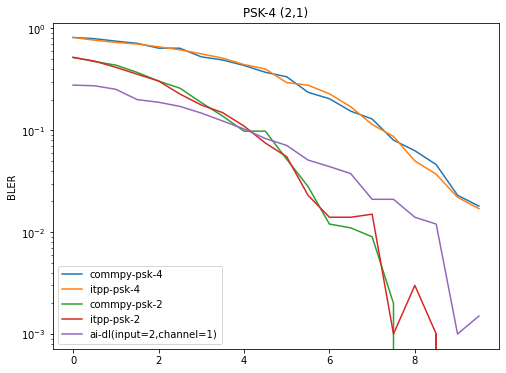

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="itpp-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl(input=2,channel=1)") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('PSK-4 ({},{})'.format(input_message_length,channel_size))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
#plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
plt.legend ()
plt.show()

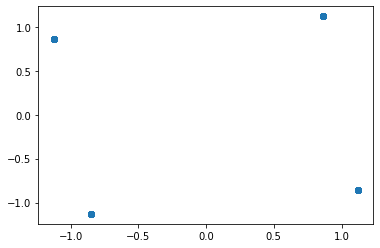

In [42]:
import matplotlib.pyplot as plt
plt.scatter(channel_x, channel_y)
plt.show()

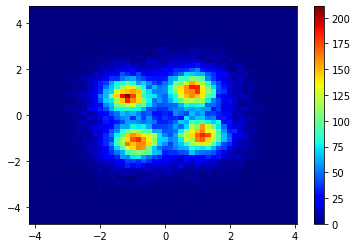

In [43]:
import matplotlib.pyplot as plt
plt.hist2d(channel_n_x, channel_n_y, (50, 50), cmap=plt.cm.jet)
plt.colorbar()
plt.show()

In [58]:
# PSK-4 (QPSK) Equivalant, larger block size 
channel_size = 5
input_message_length = 10
num_hidden_1 = 2 * channel_size 
print ("input_message_length=", input_message_length, "channel_size", channel_size)

input_message_x = tf.placeholder("float32", [None, input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, 2 * channel_size], name="input_channel_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length, input_message_length], -1, 1), name="encoder_l1_weights"),
  "encoder_l2" : tf.Variable (tf.random_uniform([input_message_length, num_hidden_1], -1, 1), name="encoder_l2_weights"),

  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1, input_message_length], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length, input_message_length], -1, 1), name="decoder_l2_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="encoder_l1_bias"),
  "encoder_l2" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l2_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l2_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  layer_2 = tf.nn.tanh (tf.matmul(layer_1, weights['encoder_l2']) + biases['encoder_l2'])
  #layer_2 = tf.round(layer_1)
  layer_3 =  layer_2 / tf.sqrt(tf.reduce_mean(tf.square(layer_2)))
  #layer_2 =  tf.nn.relu(layer_1)
  return layer_3

def dl_decoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = tf.nn.sigmoid (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  return layer_2

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)


loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))
lr = tf.placeholder(dtype=tf.float32,shape=[])
opt = tf.train.AdamOptimizer(learning_rate=lr).minimize (loss1)


awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [2*channel_size])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)


input_message_length= 10 channel_size 5


In [59]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))


[[1 0 1 ... 1 0 1]
 [1 1 1 ... 1 0 1]
 [0 0 1 ... 0 0 1]
 ...
 [1 1 1 ... 1 1 0]
 [1 1 0 ... 1 1 1]
 [1 0 1 ... 1 1 0]]
10000


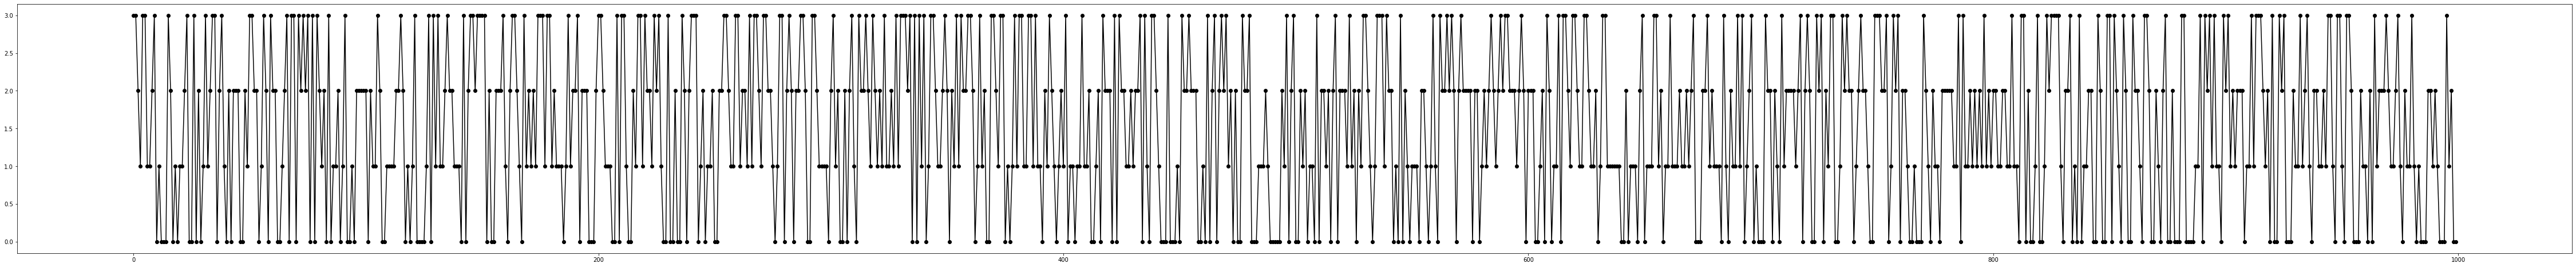

In [46]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE*10)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:NUM_OF_INPUT_MESSAGE],training_input_message_decimal[:NUM_OF_INPUT_MESSAGE], '-ok')

In [61]:
batch_size = 500


# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 70
outer_ephocs = 1
num_of_batches = len(training_input_message) / batch_size
display_step = 400
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = 0.1
i = 0
for oe in range(outer_ephocs):
  for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
    sigma = 1.0*Snr2Sigma (snr)
    print ("Training for SNR=", snr, " sigma=", sigma) 
    for e in range(epochs):
      for j in range (int(num_of_batches)):
        i = i + 1
        k = e * epochs + j
        x_train_batch = training_input_message [j*batch_size:(j+1)*batch_size]
        x_train_batch_float = x_train_batch.astype("float32")
        _, l = train_sess.run ([opt, loss1], feed_dict={input_message_x:x_train_batch_float, awgn_noise_std_dev_x:sigma, lr:lrate})
        if (l < 0.5): lrate = 0.02
        if (l < 0.25): lrate = 0.002
        if (l < 0.1): lrate = 0.0006
        if k % display_step == 0:
          print('Step %i: Minibatch Loss: %f' % (i, l))

batch_size: 500 num_of_batcches: 20.0
Training for SNR= 0.0  sigma= 1.0
Step 1: Minibatch Loss: 1.027774
Step 351: Minibatch Loss: 0.437588
Step 801: Minibatch Loss: 0.427588
Step 1151: Minibatch Loss: 0.425038
Training for SNR= 0.5  sigma= 0.9440608762859234
Step 1401: Minibatch Loss: 0.401451
Step 1751: Minibatch Loss: 0.400754
Step 2201: Minibatch Loss: 0.375741
Step 2551: Minibatch Loss: 0.389845
Training for SNR= 1.0  sigma= 0.8912509381337456
Step 2801: Minibatch Loss: 0.362321
Step 3151: Minibatch Loss: 0.350784
Step 3601: Minibatch Loss: 0.370257
Step 3951: Minibatch Loss: 0.364839
Training for SNR= 1.5  sigma= 0.8413951416451951
Step 4201: Minibatch Loss: 0.352816
Step 4551: Minibatch Loss: 0.333098
Step 5001: Minibatch Loss: 0.356121
Step 5351: Minibatch Loss: 0.351101
Training for SNR= 2.0  sigma= 0.7943282347242815
Step 5601: Minibatch Loss: 0.317986
Step 5951: Minibatch Loss: 0.322789
Step 6401: Minibatch Loss: 0.320624
Step 6751: Minibatch Loss: 0.335198
Training for SNR=

In [62]:
# Here I am using trained model
NUM_OF_INPUT_MESSAGE_BER = NUM_OF_INPUT_MESSAGE * 2
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

channel_in = []
channel_out = []
for snr in numpy.arange (0, 10, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE_BER):
    input_message_xx = training_input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    channel_in.append(encoded_message[0][0])
    #print (encoded_message[0][0])
    awgn_channel_output_message = train_sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    channel_out.append(awgn_channel_output_message[0]) 
    #print (awgn_channel_output_message[0])
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-training_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE_BER
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.30s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.56s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.81s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.07s
SNR: 0.000 - Iter: 1250 - Last 250.0 iterations took 1.33s
SNR: 0.000 - Iter: 1500 - Last 250.0 iterations took 1.59s
SNR: 0.000 - Iter: 1750 - Last 250.0 iterations took 1.83s
SNR: 0.000 - Iter: 2000 - Last 250.0 iterations took 2.10s
SNR: 0.000:
 -> BER: 0.83
 -> Total Time: 9.59s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.25s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.50s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.75s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.00s
SNR: 0.500 - Iter: 1250 - Last 250.0 iterations took 1.26s
SNR: 0.500 - Iter: 1500 - Last 250.0 iterations took 1.53s
SNR: 0.500 - Iter: 1750 - Last 250.0 iterations took 1.80s
SNR: 0.500 - Iter: 2000 - Last 250.0 iterations took 2.05s
SNR: 0.500:
 -

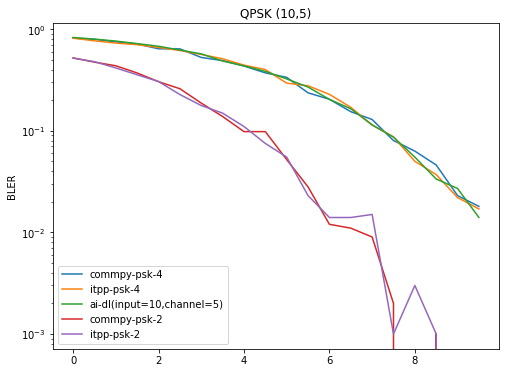

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="itpp-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl(input=10,channel=5)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="commpy-psk-2") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-psk-2") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('QPSK ({},{})'.format(input_message_length, channel_size))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
plt.legend ()
plt.show()

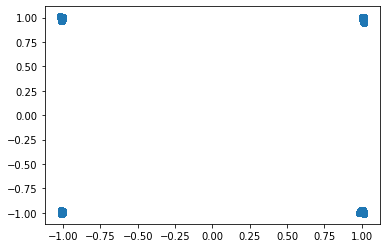

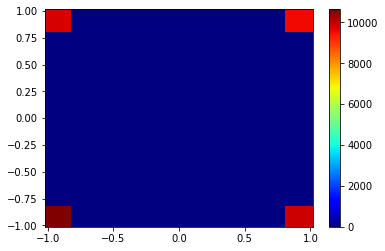

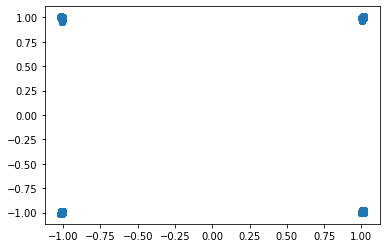

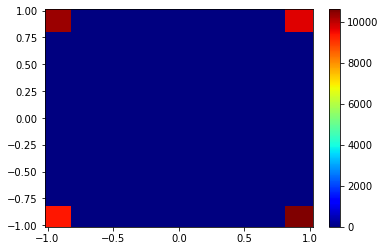

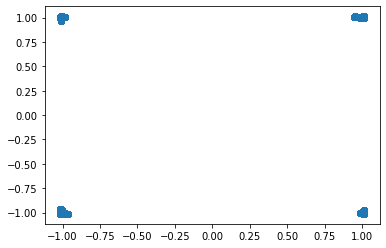

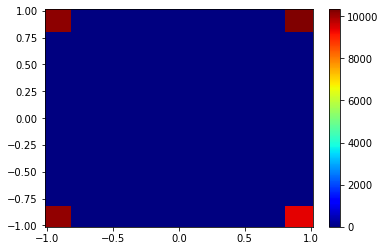

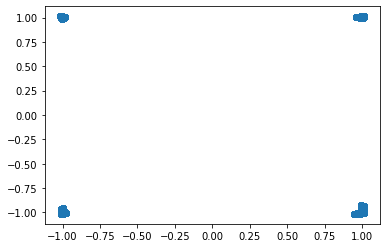

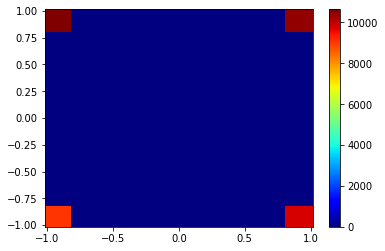

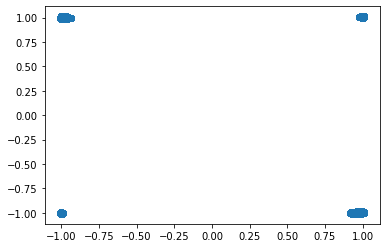

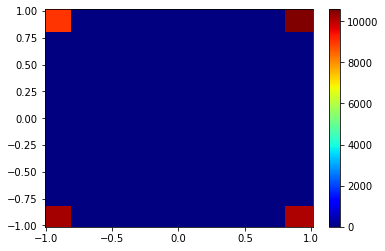

In [64]:
import matplotlib.pyplot as plt
channel_in_array = numpy.transpose(channel_in)
for i in range (int(channel_size)):
  plt.scatter(channel_in_array[i*2], channel_in_array[i*2+1])
  plt.show()
  plt.hist2d(channel_in_array[i*2], channel_in_array[i*2+1], cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

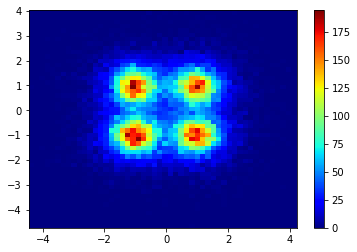

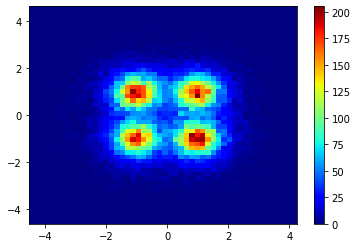

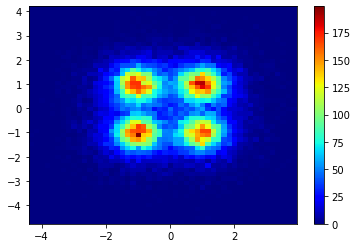

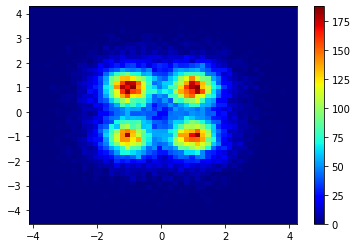

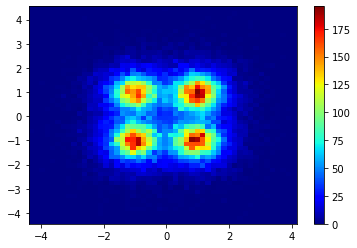

In [65]:
channel_out_array = numpy.transpose(channel_out)
for i in range (int(channel_size)):
  plt.hist2d(channel_out_array[2*i], channel_out_array[2*i+1], (50, 50), cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

In [66]:
# PSK-8 (Primitive)
channel_size = 1
input_message_length = 3
num_hidden_1 = 2 * channel_size
print(num_hidden_1) 
print ("input_message_length=", input_message_length, "channel_size", channel_size)

input_message_x = tf.placeholder("float32", [None, input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, 2 * channel_size], name="input_channel_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length, input_message_length], -1, 1), name="encoder_l1_weights"),
  "encoder_l2" : tf.Variable (tf.random_uniform([input_message_length, num_hidden_1], -1, 1), name="encoder_l2_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1, input_message_length], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length, input_message_length], -1, 1), name="decoder_l2_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="encoder_l1_bias"),
  "encoder_l2" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l2_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l2_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  layer_2 = tf.nn.tanh (tf.matmul(layer_1, weights['encoder_l2']) + biases['encoder_l2'])
  #layer_2 = tf.round(layer_1)
  layer_3 =  layer_2 / tf.sqrt(tf.reduce_mean(tf.square(layer_2)))
  #layer_2 =  tf.nn.relu(layer_1)
  return layer_3

def dl_decoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = tf.nn.sigmoid (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  return layer_2

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)


loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))
lr = tf.placeholder(dtype=tf.float32,shape=[])
opt = tf.train.AdamOptimizer(learning_rate=lr).minimize (loss1)


awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [2*channel_size])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)


2
input_message_length= 3 channel_size 1


In [67]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

[[0 0 1]
 [0 0 1]
 [0 0 1]
 ...
 [1 0 1]
 [1 1 0]
 [1 0 1]]
10000


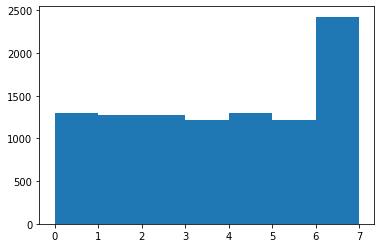

In [68]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
training_input_message_decimal = row_bits2int(training_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
y_axis = row_bits2int(training_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(training_input_message_decimal, bins = x_axis) 
plt.show()


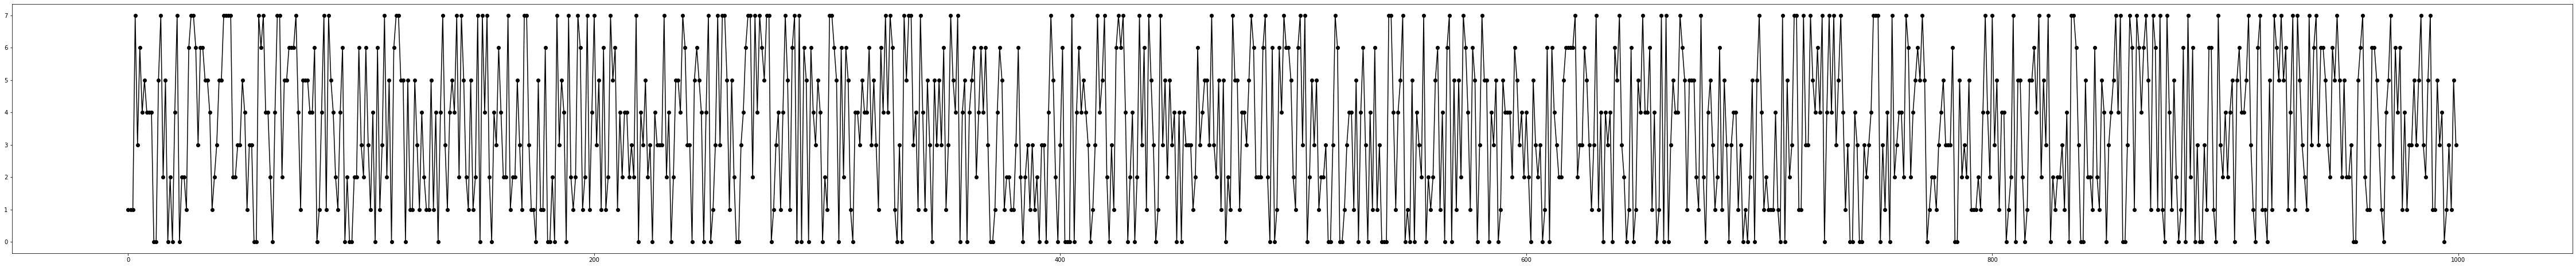

In [69]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE*10)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:NUM_OF_INPUT_MESSAGE],training_input_message_decimal[:NUM_OF_INPUT_MESSAGE], '-ok')


In [70]:
batch_size = 450


# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 70
outer_ephocs = 1
num_of_batches = len(training_input_message) / batch_size
display_step = 400
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = 0.1
i = 0
for oe in range(outer_ephocs):
  for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
    sigma = 1.0*Snr2Sigma (snr)
    print ("Training for SNR=", snr, " sigma=", sigma) 
    for e in range(epochs):
      for j in range (int(num_of_batches)):
        i = i + 1
        k = e * epochs + j
        x_train_batch = training_input_message [j*batch_size:(j+1)*batch_size]
        x_train_batch_float = x_train_batch.astype("float32")
        _, l = train_sess.run ([opt, loss1], feed_dict={input_message_x:x_train_batch_float, awgn_noise_std_dev_x:sigma, lr:lrate})
        if (l < 0.5): lrate = 0.002
        if (l < 0.25): lrate = 0.0006
        if (l < 0.1): lrate = 0.0002
        if k % display_step == 0:
          print('Step %i: Minibatch Loss: %f' % (i, l))


batch_size: 450 num_of_batcches: 22.22222222222222
Training for SNR= 0.0  sigma= 1.0
Step 1: Minibatch Loss: 0.785922
Step 385: Minibatch Loss: 0.481548
Step 769: Minibatch Loss: 0.466501
Step 881: Minibatch Loss: 0.457829
Step 1265: Minibatch Loss: 0.452080
Training for SNR= 0.5  sigma= 0.9440608762859234
Step 1541: Minibatch Loss: 0.463954
Step 1925: Minibatch Loss: 0.445606
Step 2309: Minibatch Loss: 0.442102
Step 2421: Minibatch Loss: 0.469252
Step 2805: Minibatch Loss: 0.453300
Training for SNR= 1.0  sigma= 0.8912509381337456
Step 3081: Minibatch Loss: 0.420014
Step 3465: Minibatch Loss: 0.446878
Step 3849: Minibatch Loss: 0.434180
Step 3961: Minibatch Loss: 0.425234
Step 4345: Minibatch Loss: 0.437861
Training for SNR= 1.5  sigma= 0.8413951416451951
Step 4621: Minibatch Loss: 0.413799
Step 5005: Minibatch Loss: 0.410476
Step 5389: Minibatch Loss: 0.426142
Step 5501: Minibatch Loss: 0.441622
Step 5885: Minibatch Loss: 0.415006
Training for SNR= 2.0  sigma= 0.7943282347242815
Step 

In [71]:
# Here I am using trained model
NUM_OF_INPUT_MESSAGE_BER = NUM_OF_INPUT_MESSAGE * 2
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

channel_in = []
channel_out = []
for snr in numpy.arange (0, 10, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE_BER):
    input_message_xx = training_input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    channel_in.append(encoded_message[0][0])
    #print (encoded_message[0][0])
    awgn_channel_output_message = train_sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    channel_out.append(awgn_channel_output_message[0]) 
    #print (awgn_channel_output_message[0])
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-training_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE_BER
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.32s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.57s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.82s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.11s
SNR: 0.000 - Iter: 1250 - Last 250.0 iterations took 1.36s
SNR: 0.000 - Iter: 1500 - Last 250.0 iterations took 1.62s
SNR: 0.000 - Iter: 1750 - Last 250.0 iterations took 1.87s
SNR: 0.000 - Iter: 2000 - Last 250.0 iterations took 2.14s
SNR: 0.000:
 -> BER: 0.63
 -> Total Time: 9.81s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.26s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.51s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.77s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.02s
SNR: 0.500 - Iter: 1250 - Last 250.0 iterations took 1.27s
SNR: 0.500 - Iter: 1500 - Last 250.0 iterations took 1.54s
SNR: 0.500 - Iter: 1750 - Last 250.0 iterations took 1.81s
SNR: 0.500 - Iter: 2000 - Last 250.0 iterations took 2.07s
SNR: 0.500:
 -

In [73]:
bler_per_iter_uncoded_itpp_psk_8 = [0.929, 0.924, 0.91,  0.888, 0.863, 0.829, 0.835, 0.833, 0.764, 0.728, 0.71,  0.642, 0.625, 0.585, 0.526, 0.474, 0.43,  0.391, 0.358, 0.284]
bler_per_iter_uncoded_commpy_psk_8= [0.925, 0.911, 0.895, 0.891, 0.873, 0.853, 0.823, 0.822, 0.764, 0.745, 0.699, 0.7, 0.611, 0.614, 0.531, 0.493, 0.433, 0.424, 0.323, 0.273]

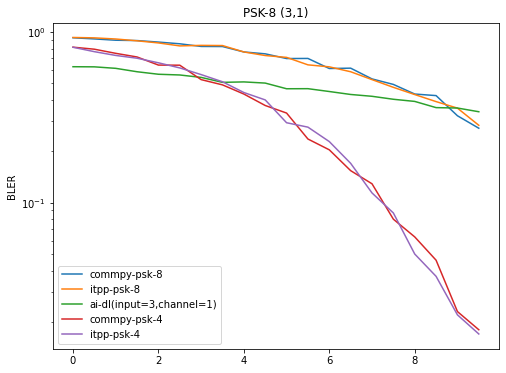

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_8,'', label="commpy-psk-8") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_8,'', label="itpp-psk-8") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl(input=3,channel=1)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="itpp-psk-4") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('PSK-8 ({},{})'.format(input_message_length,channel_size))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
plt.legend ()
plt.show()


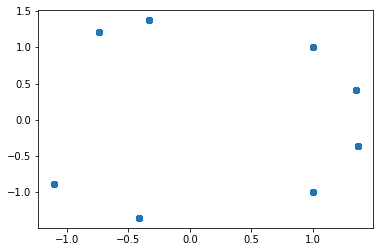

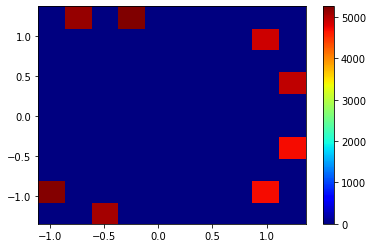

In [75]:
import matplotlib.pyplot as plt
channel_in_array = numpy.transpose(channel_in)

for i in range (int(channel_size)):
  plt.scatter(channel_in_array[i*2], channel_in_array[i*2+1])
  plt.show()
  plt.hist2d(channel_in_array[i*2], channel_in_array[i*2+1], cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

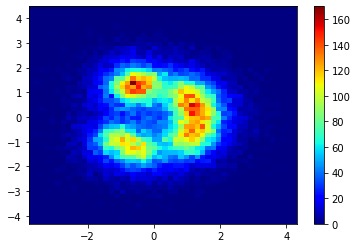

In [76]:
channel_out_array = numpy.transpose(channel_out)

for i in range (int(channel_size)):
  plt.hist2d(channel_out_array[2*i], channel_out_array[2*i+1], (50, 50), cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

In [79]:
#PSK-8 (Larger Block Size)
channel_size = 3
input_message_length = 9
num_hidden_1 = 2 * channel_size
print(num_hidden_1) 
print ("input_message_length=", input_message_length, "channel_size", channel_size)

input_message_x = tf.placeholder("float32", [None, input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, 2 * channel_size], name="input_channel_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length, input_message_length], -1, 1), name="encoder_l1_weights"),
  "encoder_l2" : tf.Variable (tf.random_uniform([input_message_length, num_hidden_1], -1, 1), name="encoder_l2_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1, input_message_length], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length, input_message_length], -1, 1), name="decoder_l2_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="encoder_l1_bias"),
  "encoder_l2" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l2_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l2_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  layer_2 = tf.nn.tanh (tf.matmul(layer_1, weights['encoder_l2']) + biases['encoder_l2'])
  #layer_2 = tf.round(layer_1)
  layer_3 =  layer_2 / tf.sqrt(tf.reduce_mean(tf.square(layer_2)))
  #layer_2 =  tf.nn.relu(layer_1)
  return layer_3

def dl_decoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = tf.nn.sigmoid (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  return layer_2

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)


loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))
lr = tf.placeholder(dtype=tf.float32,shape=[])
opt = tf.train.AdamOptimizer(learning_rate=lr).minimize (loss1)


awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [2*channel_size])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)


6
input_message_length= 9 channel_size 3


In [80]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

[[1 0 0 ... 0 0 1]
 [1 0 0 ... 1 0 0]
 [1 1 0 ... 1 0 1]
 ...
 [0 1 0 ... 0 1 0]
 [0 0 0 ... 1 0 1]
 [0 0 1 ... 1 1 0]]
10000


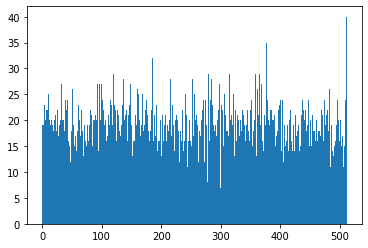

In [81]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
training_input_message_decimal = row_bits2int(training_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
y_axis = row_bits2int(training_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(training_input_message_decimal, bins = x_axis) 
plt.show()

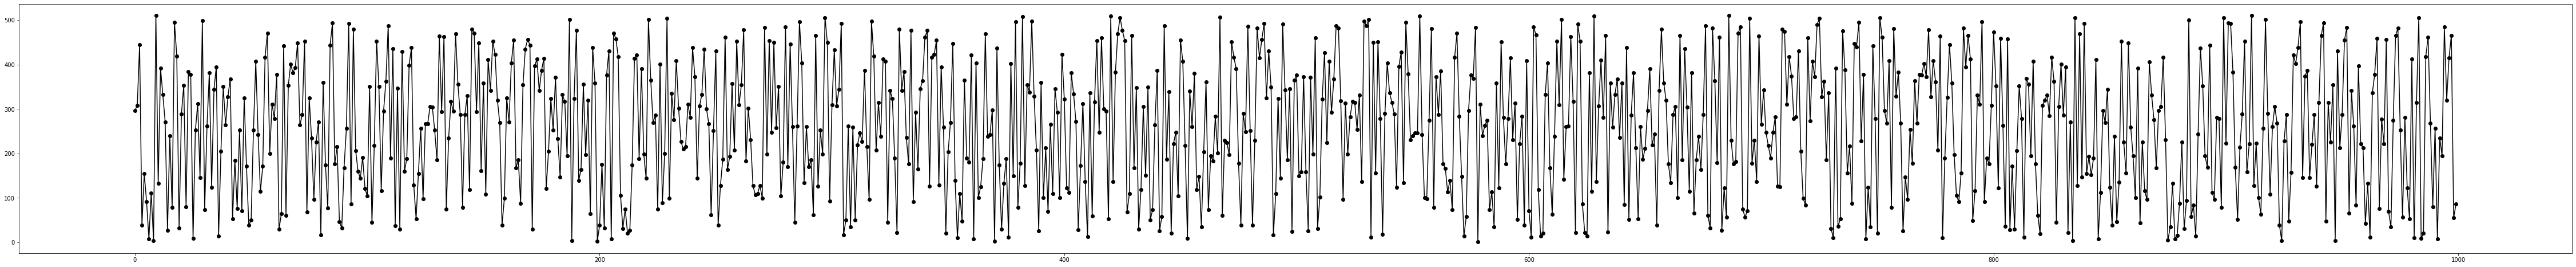

In [82]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE*10)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:NUM_OF_INPUT_MESSAGE],training_input_message_decimal[:NUM_OF_INPUT_MESSAGE], '-ok')



In [83]:
batch_size = 500


# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 80
outer_ephocs = 1
num_of_batches = len(training_input_message) / batch_size
display_step = 400
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = 0.1
i = 0
for oe in range(outer_ephocs):
  for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
    sigma = 1.0*Snr2Sigma (snr)
    print ("Training for SNR=", snr, " sigma=", sigma) 
    for e in range(epochs):
      for j in range (int(num_of_batches)):
        i = i + 1
        k = e * epochs + j
        x_train_batch = training_input_message [j*batch_size:(j+1)*batch_size]
        x_train_batch_float = x_train_batch.astype("float32")
        _, l = train_sess.run ([opt, loss1], feed_dict={input_message_x:x_train_batch_float, awgn_noise_std_dev_x:sigma, lr:lrate})
        if (l < 0.5): lrate = 0.01
        if (l < 0.25): lrate = 0.0008
        if (l < 0.1): lrate = 0.0001
        if k % display_step == 0:
          print('Step %i: Minibatch Loss: %f' % (i, l))

batch_size: 500 num_of_batcches: 20.0
Training for SNR= 0.0  sigma= 1.0
Step 1: Minibatch Loss: 0.900948
Step 101: Minibatch Loss: 0.493565
Step 201: Minibatch Loss: 0.484796
Step 301: Minibatch Loss: 0.465660
Step 401: Minibatch Loss: 0.475924
Step 501: Minibatch Loss: 0.458639
Step 601: Minibatch Loss: 0.482376
Step 701: Minibatch Loss: 0.478276
Step 801: Minibatch Loss: 0.475040
Step 901: Minibatch Loss: 0.474017
Step 1001: Minibatch Loss: 0.470308
Step 1101: Minibatch Loss: 0.459328
Step 1201: Minibatch Loss: 0.467434
Step 1301: Minibatch Loss: 0.458450
Step 1401: Minibatch Loss: 0.482929
Step 1501: Minibatch Loss: 0.470823
Training for SNR= 0.5  sigma= 0.9440608762859234
Step 1601: Minibatch Loss: 0.454054
Step 1701: Minibatch Loss: 0.459271
Step 1801: Minibatch Loss: 0.450596
Step 1901: Minibatch Loss: 0.451678
Step 2001: Minibatch Loss: 0.455330
Step 2101: Minibatch Loss: 0.474387
Step 2201: Minibatch Loss: 0.449452
Step 2301: Minibatch Loss: 0.460844
Step 2401: Minibatch Loss: 

In [85]:
# Here I am using trained model
NUM_OF_INPUT_MESSAGE_BER = NUM_OF_INPUT_MESSAGE * 2
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

channel_in = []
channel_out = []
for snr in numpy.arange (0, 10, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE_BER):
    input_message_xx = training_input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    channel_in.append(encoded_message[0][0])
    #print (encoded_message[0][0])
    awgn_channel_output_message = train_sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    channel_out.append(awgn_channel_output_message[0]) 
    #print (awgn_channel_output_message[0])
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-training_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE_BER
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.28s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.52s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.78s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.06s
SNR: 0.000 - Iter: 1250 - Last 250.0 iterations took 1.35s
SNR: 0.000 - Iter: 1500 - Last 250.0 iterations took 1.67s
SNR: 0.000 - Iter: 1750 - Last 250.0 iterations took 2.01s
SNR: 0.000 - Iter: 2000 - Last 250.0 iterations took 2.34s
SNR: 0.000:
 -> BER: 0.96
 -> Total Time: 10.01s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.32s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.65s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.99s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.32s
SNR: 0.500 - Iter: 1250 - Last 250.0 iterations took 1.65s
SNR: 0.500 - Iter: 1500 - Last 250.0 iterations took 1.98s
SNR: 0.500 - Iter: 1750 - Last 250.0 iterations took 2.32s
SNR: 0.500 - Iter: 2000 - Last 250.0 iterations took 2.65s
SNR: 0.500:
 

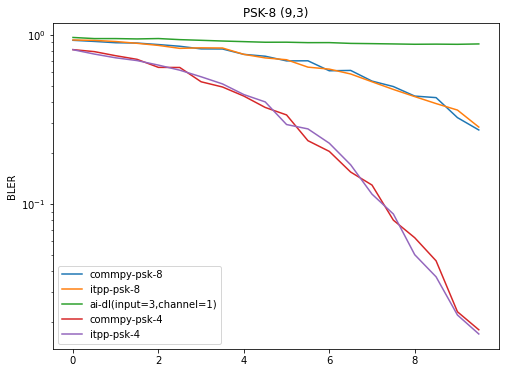

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_8,'', label="commpy-psk-8") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_8,'', label="itpp-psk-8") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl(input=3,channel=1)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_4,'', label="commpy-psk-4") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_4,'', label="itpp-psk-4") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('PSK-8 ({},{})'.format(input_message_length,channel_size))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
plt.legend ()
plt.show()


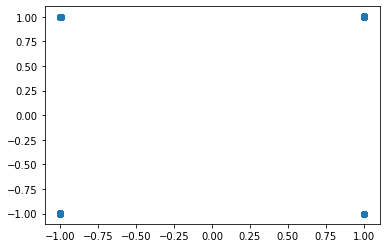

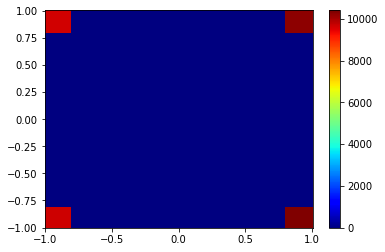

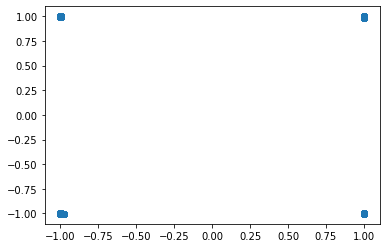

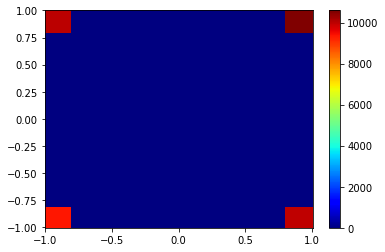

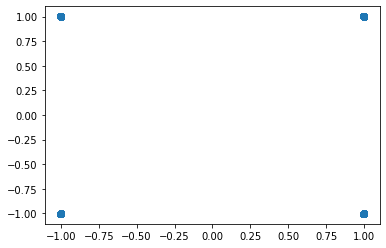

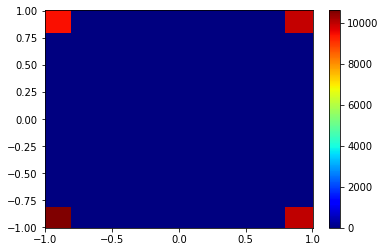

In [87]:
import matplotlib.pyplot as plt
channel_in_array = numpy.transpose(channel_in)

for i in range (int(channel_size)):
  plt.scatter(channel_in_array[i*2], channel_in_array[i*2+1])
  plt.show()
  plt.hist2d(channel_in_array[i*2], channel_in_array[i*2+1], cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()


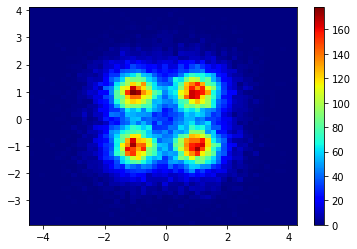

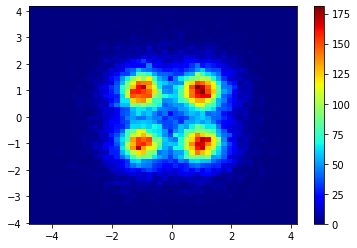

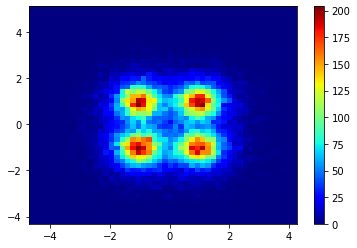

In [88]:
channel_out_array = numpy.transpose(channel_out)

for i in range (int(channel_size)):
  plt.hist2d(channel_out_array[2*i], channel_out_array[2*i+1], (50, 50), cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

In [89]:
# ARCH 2 : 9-18-9
channel_size = 9
input_message_length = 9
num_hidden_1 = 2 * channel_size
print(num_hidden_1) 
print ("input_message_length=", input_message_length, "channel_size", channel_size)

input_message_x = tf.placeholder("float32", [None, input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, 2 * channel_size], name="input_channel_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length, 2*input_message_length], -1, 1), name="encoder_l1_weights"),
  "encoder_l2" : tf.Variable (tf.random_uniform([2*input_message_length, num_hidden_1], -1, 1), name="encoder_l2_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1, 2*input_message_length], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([2*input_message_length, input_message_length], -1, 1), name="decoder_l2_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([2*input_message_length], -1,1), name="encoder_l1_bias"),
  "encoder_l2" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l2_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([2*input_message_length], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l2_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  layer_2 = tf.nn.tanh (tf.matmul(layer_1, weights['encoder_l2']) + biases['encoder_l2'])
  #layer_2 = tf.round(layer_1)
  layer_3 =  layer_2 / tf.sqrt(tf.reduce_mean(tf.square(layer_2)))
  #layer_2 =  tf.nn.relu(layer_1)
  return layer_3

def dl_decoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = tf.nn.sigmoid (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  return layer_2

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)


loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))
lr = tf.placeholder(dtype=tf.float32,shape=[])
opt = tf.train.AdamOptimizer(learning_rate=lr).minimize (loss1)


awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [2*channel_size])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)


18
input_message_length= 9 channel_size 9


In [90]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

[[1 0 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 [1 1 1 ... 1 1 0]
 ...
 [0 1 0 ... 1 1 1]
 [1 0 0 ... 0 0 1]
 [0 1 0 ... 1 0 1]]
10000


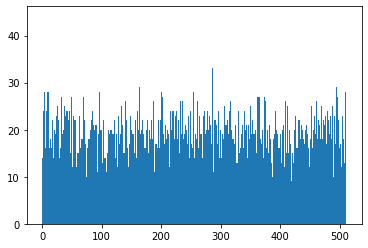

In [91]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
training_input_message_decimal = row_bits2int(training_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
y_axis = row_bits2int(training_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(training_input_message_decimal, bins = x_axis) 
plt.show()

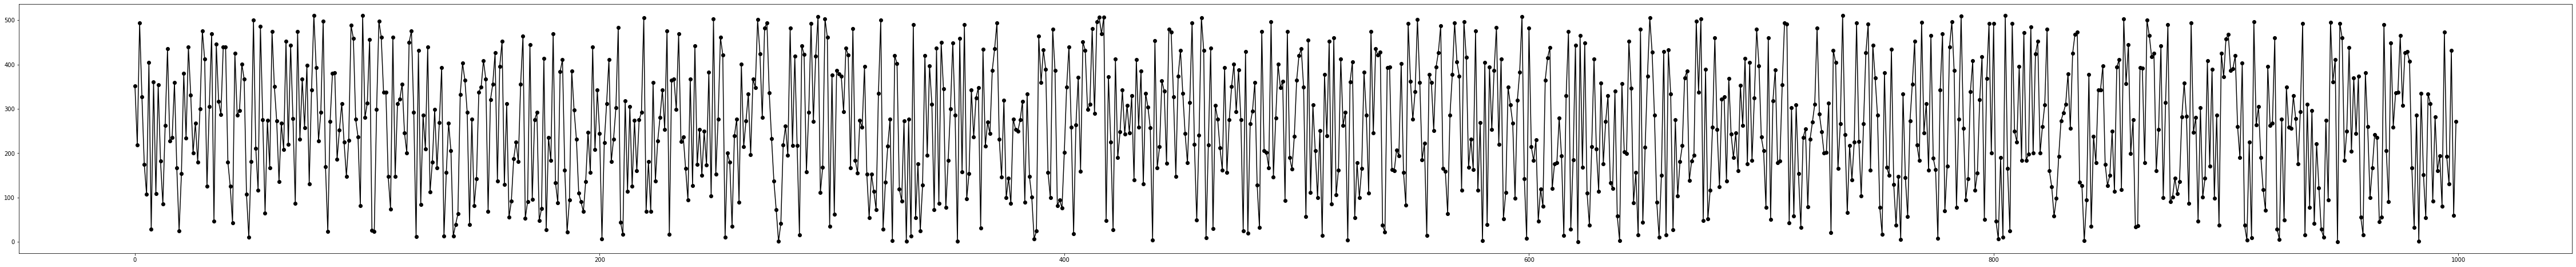

In [92]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE*10)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:NUM_OF_INPUT_MESSAGE],training_input_message_decimal[:NUM_OF_INPUT_MESSAGE], '-ok')


In [93]:

batch_size = 400


# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 50
outer_ephocs = 1
num_of_batches = len(training_input_message) / batch_size
display_step = 400
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = 0.1
i = 0
for oe in range(outer_ephocs):
  for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
    sigma = 1.0*Snr2Sigma (snr)
    print ("Training for SNR=", snr, " sigma=", sigma) 
    for e in range(epochs):
      for j in range (int(num_of_batches)):
        i = i + 1
        k = e * epochs + j
        x_train_batch = training_input_message [j*batch_size:(j+1)*batch_size]
        x_train_batch_float = x_train_batch.astype("float32")
        _, l = train_sess.run ([opt, loss1], feed_dict={input_message_x:x_train_batch_float, awgn_noise_std_dev_x:sigma, lr:lrate})
        if (l < 0.5): lrate = 0.001
        if (l < 0.25): lrate = 0.0005
        if (l < 0.1): lrate = 0.0002
        if k % display_step == 0:
          print('Step %i: Minibatch Loss: %f' % (i, l))

batch_size: 400 num_of_batcches: 25.0
Training for SNR= 0.0  sigma= 1.0
Step 1: Minibatch Loss: 1.071717
Step 201: Minibatch Loss: 0.397642
Step 401: Minibatch Loss: 0.378166
Step 601: Minibatch Loss: 0.341586
Step 801: Minibatch Loss: 0.309488
Step 1001: Minibatch Loss: 0.294539
Step 1201: Minibatch Loss: 0.272703
Training for SNR= 0.5  sigma= 0.9440608762859234
Step 1251: Minibatch Loss: 0.263008
Step 1451: Minibatch Loss: 0.255404
Step 1651: Minibatch Loss: 0.230403
Step 1851: Minibatch Loss: 0.228626
Step 2051: Minibatch Loss: 0.238722
Step 2251: Minibatch Loss: 0.226920
Step 2451: Minibatch Loss: 0.220481
Training for SNR= 1.0  sigma= 0.8912509381337456
Step 2501: Minibatch Loss: 0.202811
Step 2701: Minibatch Loss: 0.190492
Step 2901: Minibatch Loss: 0.194171
Step 3101: Minibatch Loss: 0.162922
Step 3301: Minibatch Loss: 0.165536
Step 3501: Minibatch Loss: 0.161839
Step 3701: Minibatch Loss: 0.167737
Training for SNR= 1.5  sigma= 0.8413951416451951
Step 3751: Minibatch Loss: 0.145

In [94]:
# Here I am using trained model
NUM_OF_INPUT_MESSAGE_BER = NUM_OF_INPUT_MESSAGE * 2
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

channel_in = []
channel_out = []
for snr in numpy.arange (0, 10, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE_BER):
    input_message_xx = training_input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    channel_in.append(encoded_message[0][0])
    #print (encoded_message[0][0])
    awgn_channel_output_message = train_sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    channel_out.append(awgn_channel_output_message[0]) 
    #print (awgn_channel_output_message[0])
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-training_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE_BER
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.33s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.58s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.85s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.11s
SNR: 0.000 - Iter: 1250 - Last 250.0 iterations took 1.36s
SNR: 0.000 - Iter: 1500 - Last 250.0 iterations took 1.62s
SNR: 0.000 - Iter: 1750 - Last 250.0 iterations took 1.90s
SNR: 0.000 - Iter: 2000 - Last 250.0 iterations took 2.19s
SNR: 0.000:
 -> BER: 0.52
 -> Total Time: 9.95s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.27s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.53s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.82s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.09s
SNR: 0.500 - Iter: 1250 - Last 250.0 iterations took 1.36s
SNR: 0.500 - Iter: 1500 - Last 250.0 iterations took 1.62s
SNR: 0.500 - Iter: 1750 - Last 250.0 iterations took 1.87s
SNR: 0.500 - Iter: 2000 - Last 250.0 iterations took 2.12s
SNR: 0.500:
 -

In [95]:
bler_per_iter_ldpc_itpp_psk_4 = [0.584, 0.488, 0.404, 0.332, 0.218, 0.151, 0.097, 0.058, 0.041, 0.024, 0.007, 0.004, 0.002, 0.001, 0.001, 0.,    0.,    0.,    0.,    0.,   ]
bler_per_iter_ham_itpp_psk_4= [0.51, 0.479, 0.419, 0.333, 0.313, 0.247, 0.212, 0.132, 0.114, 0.093, 0.042, 0.027, 0.024, 0.016, 0.006, 0.005, 0.003, 0.002, 0.,    0.  ]

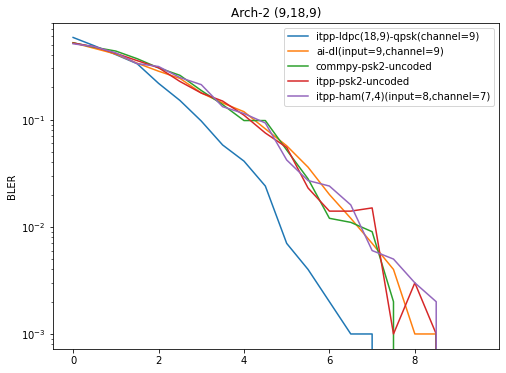

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc(18,9)-qpsk(channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl(input=9,channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="commpy-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham(7,4)(input=8,channel=7)") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('Arch-2 ({},{},{})'.format(input_message_length,2*input_message_length, channel_size))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
plt.legend ()
plt.show()

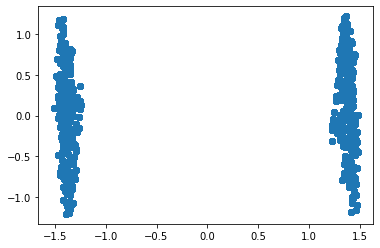

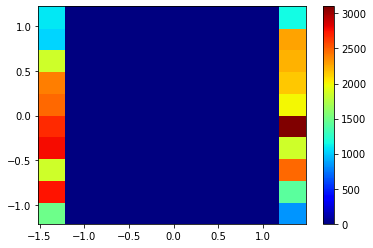

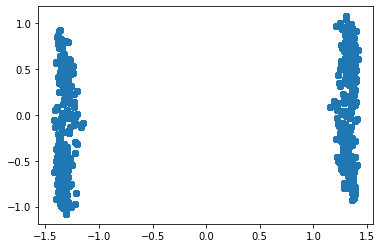

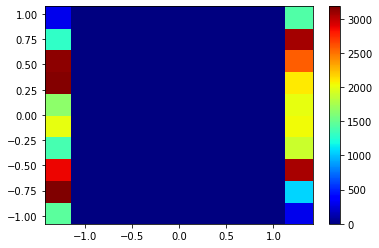

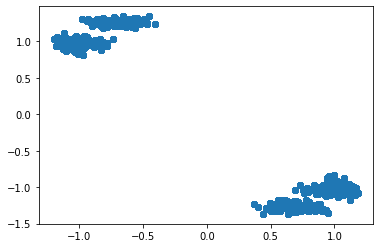

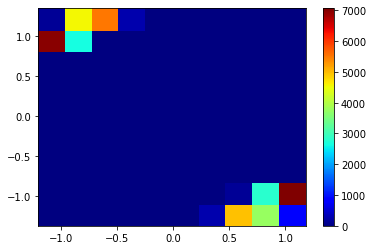

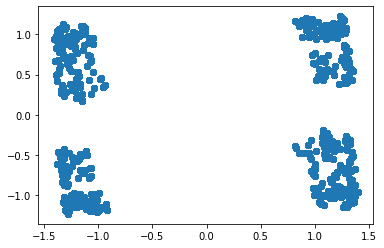

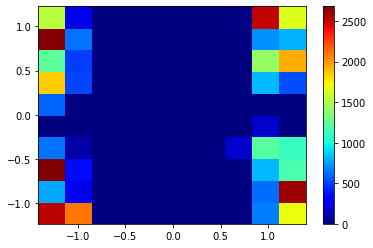

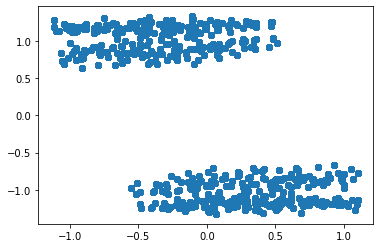

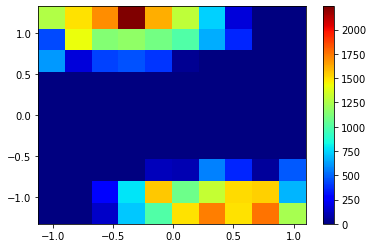

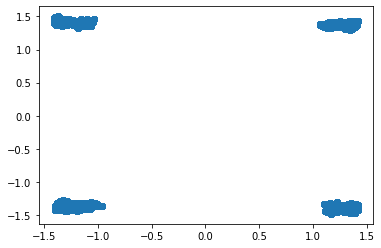

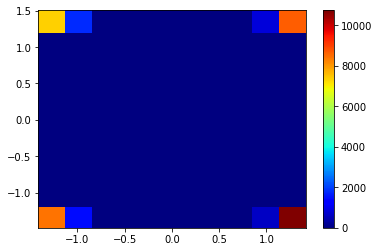

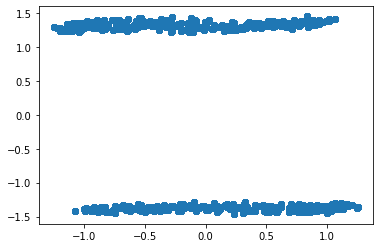

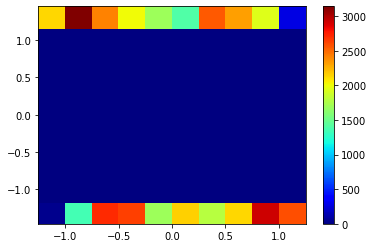

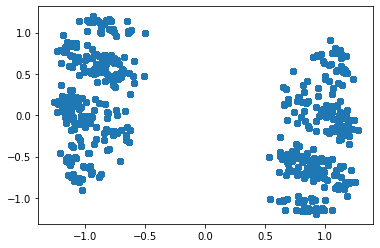

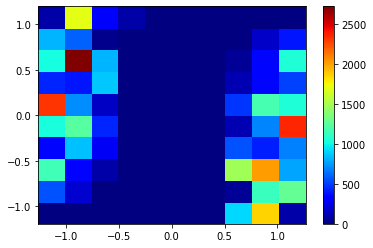

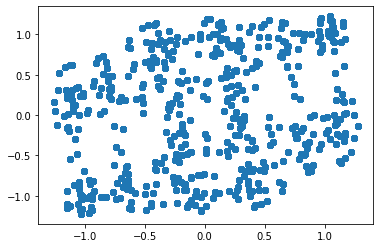

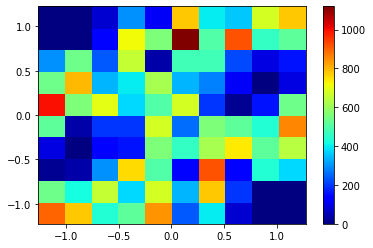

In [98]:
import matplotlib.pyplot as plt
channel_in_array = numpy.transpose(channel_in)

for i in range (int(channel_size)):
  plt.scatter(channel_in_array[i*2], channel_in_array[i*2+1])
  plt.show()
  plt.hist2d(channel_in_array[i*2], channel_in_array[i*2+1], cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

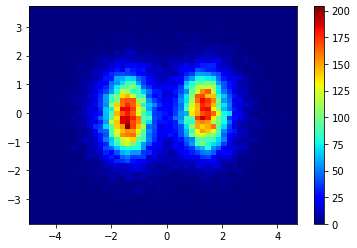

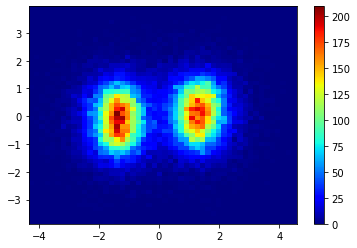

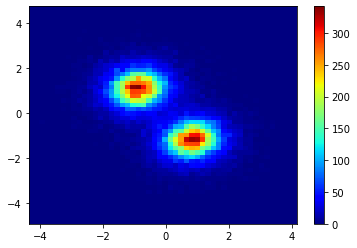

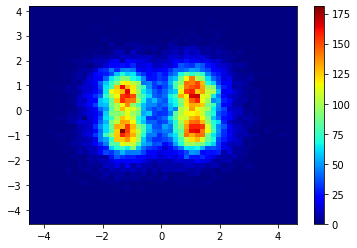

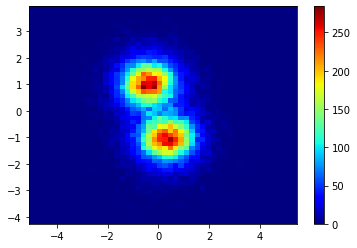

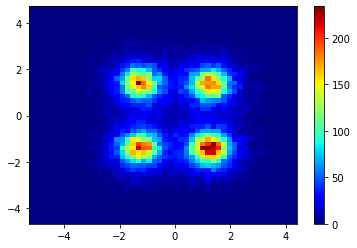

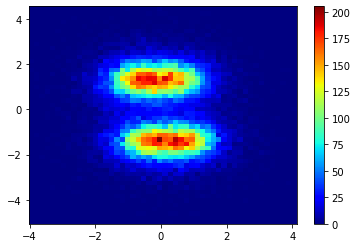

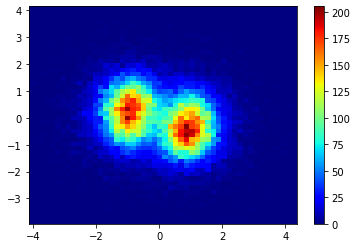

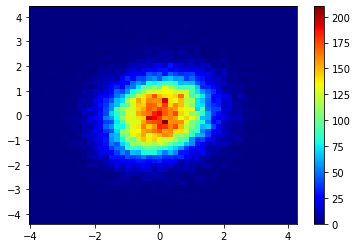

In [99]:
channel_out_array = numpy.transpose(channel_out)

for i in range (int(channel_size)):
  plt.hist2d(channel_out_array[2*i], channel_out_array[2*i+1], (50, 50), cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

In [ ]:

class GetOutOfLoop( Exception ):
    pass

# ARCH-2 : 9-18-9 : But One Hot Input

channel_size = 9
input_message_length = 9
num_hidden_1 = 2 * channel_size
print(num_hidden_1) 
print ("input_message_length=", input_message_length, "channel_size", channel_size)

lr_x = tf.placeholder(dtype=tf.float32,shape=[])
input_message_x_label = tf.placeholder("int32", [None], name="input_message_x_label")
input_message_x = tf.placeholder("float32", [None, 2**input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, 2 * channel_size], name="input_channel_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([2**input_message_length, 2*input_message_length], -1, 1), name="encoder_l1_weights"),
  "encoder_l2" : tf.Variable (tf.random_uniform([2*input_message_length, num_hidden_1], -1, 1), name="encoder_l2_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1, 2*input_message_length], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([2*input_message_length, 2**input_message_length], -1, 1), name="decoder_l2_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([2*input_message_length], -1,1), name="encoder_l1_bias"),
  "encoder_l2" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l2_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([2*input_message_length], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([2**input_message_length], -1,1), name="decoder_l2_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  layer_2 = tf.nn.tanh (tf.matmul(layer_1, weights['encoder_l2']) + biases['encoder_l2'])
  #layer_2 = tf.round(layer_1)
  layer_3 =  layer_2 / tf.sqrt(tf.reduce_mean(tf.square(layer_2)))
  #layer_2 =  tf.nn.relu(layer_1)
  return layer_3

def dl_decoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  #layer_2 = tf.nn.sigmoid (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  layer_2 = (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  return layer_2

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)


#loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))
loss = tf.losses.sparse_softmax_cross_entropy(labels=input_message_x_label,logits=dl_decoder_output)
optimizer = tf.train.AdamOptimizer(learning_rate=lr_x).minimize (loss)



awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [2*channel_size])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)


In [ ]:
training_input_message = numpy.random.randint(2**input_message_length, size=(1,NUM_OF_INPUT_MESSAGE*10))
training_input_message_one_hot = numpy.zeros((training_input_message.size, 2**input_message_length))
training_input_message_one_hot[numpy.arange(training_input_message.size),training_input_message] = 1
print(training_input_message_one_hot)
print (training_input_message_one_hot.shape)
print (training_input_message.shape)

In [ ]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
#training_input_message_decimal = row_bits2int(training_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
#y_axis = row_bits2int(training_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(training_input_message[0][:-1], bins = x_axis[:-1]) 
plt.show()

In [ ]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE*10)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:-1],training_input_message[0][:-1], '-ok')

In [ ]:
batch_size = 500

# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 10
outer_ephocs = 1
display_step = 2
num_of_batches = training_input_message.shape[1] / batch_size
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = 0.1
i = 0
snr_min = 9.5
snr_max = 10.5
snr_step_size = 0.5
max_iteration = epochs * num_of_batches * (snr_max - snr_min) / snr_step_size
print ("max iteration :",max_iteration,"num_of_batches:", num_of_batches)
try:
  for oe in range(outer_ephocs):
    for snr in (numpy.arange (0, 10, SNR_STEP_SIZE)):
    #for snr in (numpy.arange (snr_min, snr_max, SNR_STEP_SIZE)):
      sigma = 1.0*Snr2Sigma (snr)
      print ("Training for SNR=", snr, " sigma=", sigma, "iteratin:", oe) 
      for e in range(epochs):
        for j in range (int(num_of_batches)):
          i = i + 1
          x_train_batch_one_hot = training_input_message_one_hot [j*batch_size:(j+1)*batch_size]
          x_train_batch_one_hot = x_train_batch_one_hot.astype("float32")
          x_train_batch_label = training_input_message.reshape(training_input_message.shape[1]) [j*batch_size:(j+1)*batch_size]        
          if (i < 100): 
            lr = 0.1
          elif(i < 200):
            lr = 0.01
          else:
            lr = 0.001 
          _, l = train_sess.run ([optimizer, loss], feed_dict={input_message_x:x_train_batch_one_hot, awgn_noise_std_dev_x:sigma, lr_x:lr, input_message_x_label:x_train_batch_label.astype("int32")})
          if i % display_step == 0:          
            print('Step %i: Minibatch Loss: %f' % (i, l ))
          if (l < 0.05 and snr >= 9): 
            print ("Loss=", l)
            raise GetOutOfLoop
except GetOutOfLoop:
  print("Early Stop")

In [ ]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

channel_in = []
channel_out = []

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  lrate = 0.001
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message_one_hot [i:i+1]
    input_message_xx = input_message_xx.astype("float32")
    #,input_message_x_label:training_input_message [i]
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx })
    channel_in.append(encoded_message[0][0])
    encoded_message = encoded_message[0][0]
    #encoded_message = numpy.around(encoded_message[0][0]> 0).astype(int)
    #print (encoded_message[0][0])
    awgn_channel_output_message = train_sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})
    channel_out.append(awgn_channel_output_message[0]) 
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    #decoded_message = numpy.around(decoded_message[0][0]> 0).astype(int)
    #rint ("output", decoded_message)
    #print ("output", numpy.argmax(training_input_message_one_hot[i]), numpy.argmax(decoded_message[0][0]))
    if (numpy.argmax(training_input_message_one_hot[i]) != numpy.argmax(decoded_message[0][0])):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc(18,9)-qpsk(channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl-onehot(input=9,channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="commpy-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham(7,4)(input=8,channel=7)") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('Arch:2 ({},{},{})'.format(input_message_length,2*input_message_length,channel_size))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
plt.legend ()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
channel_in_array = numpy.transpose(channel_in)

for i in range (int(channel_size)):
  plt.scatter(channel_in_array[i*2], channel_in_array[i*2+1])
  plt.show()
  plt.hist2d(channel_in_array[i*2], channel_in_array[i*2+1], cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

In [ ]:
channel_out_array = numpy.transpose(channel_out)

for i in range (int(channel_size)):
  plt.hist2d(channel_out_array[2*i], channel_out_array[2*i+1], (50, 50), cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

In [ ]:
# ARCH 3 : 9-18-9 
channel_size = 9
num_of_channel = channel_size
input_message_length = 9
num_hidden_1 = 2 * channel_size
encoder_output_length = 18
print(num_hidden_1) 

print ("input_message_length=", input_message_length)
print ("num_of_channel=", num_of_channel)
print ("encoder_output_length=", encoder_output_length)

num_of_hidden_layer_node = encoder_output_length

input_message_x = tf.placeholder("float32", [None, input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, num_of_channel * 2], name="input_channel_x")
input_modulator_x = tf.placeholder("float32", [None, num_of_hidden_layer_node], name="input_modulator_x")
input_dmodulator_x = tf.placeholder("float32", [None, num_of_channel * 2], name="input_dmodulator_x")
input_decoder_x = tf.placeholder("float32", [None, num_of_hidden_layer_node], name="input_decoder_x")
input_encoder_out_ex = tf.placeholder("float32", [None, encoder_output_length], name="input_encoder_out_ex")
#input_decoder_in_ex = tf.placeholder("float32", [None, num_of_hidden_layer_node], name="input_encoder_out_ex")
weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length, num_of_hidden_layer_node], -1, 1), name="encoder_l1_weights"),
  "encoder_l2" : tf.Variable (tf.random_uniform([num_of_hidden_layer_node, num_of_channel * 2], -1, 1), name="encoder_l2_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_of_channel * 2, num_of_hidden_layer_node], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([num_of_hidden_layer_node, num_of_hidden_layer_node], -1, 1), name="decoder_l2_weights"),
  "decoder_l3" : tf.Variable (tf.random_uniform([num_of_hidden_layer_node, input_message_length], -1, 1), name="decoder_l3_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([num_of_hidden_layer_node], -1,1), name="encoder_l1_bias"),
  "encoder_l2" : tf.Variable (tf.random_uniform([num_of_channel * 2], -1,1), name="encoder_l2_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_of_hidden_layer_node], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([num_of_hidden_layer_node], -1,1), name="decoder_l2_bias"),
  "decoder_l3" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l3_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  return layer_1


def dl_modulator (x):
  layer_1 = (tf.matmul(x, weights['encoder_l2']) + biases['encoder_l2'])
  layer_2 =  layer_1/ tf.sqrt(tf.reduce_mean(tf.square(layer_1)))
  #x = tf.sqrt(tf.reduce_sum(tf.square(layer_2), axis=1))
  #x = tf.reshape (x, (-1,1))
  #layer_2 = layer_1 / x
  #layer_2 =  tf.nn.relu(layer_1)
  return layer_2

#input_channel_x = tf.placeholder("float32", [None, 3], name="input_channel_x")
#x = tf.sqrt(tf.reduce_sum(tf.square(input_channel_x), axis=1))
#x = tf.reshape(x, (-1, 1))
#l = x
#l = input_channel_x / x
def dl_dmodulator (x):
  layer_1 = (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  return layer_1

def dl_decoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['decoder_l2']) + biases['decoder_l2'])
  layer_2 = tf.nn.sigmoid(tf.matmul(layer_1, weights['decoder_l3']) + biases['decoder_l3'])
  #layer_3 = tf.nn.sigmoid (tf.matmul(layer_2, weights['decoder_l3']) + biases['decoder_l3'])
  return layer_2

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_modulator_output = dl_modulator (dl_encoder_output)
channel_output = awgn_layer(dl_modulator_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_dmodulator_output = dl_dmodulator (channel_output)
dl_decoder_output = dl_decoder (dl_dmodulator_output)

dl_modulator_only_output = dl_modulator(input_modulator_x)
dl_dmodulator_only_output = dl_dmodulator (input_dmodulator_x)
dl_decoder_only_output = dl_decoder(input_decoder_x)


#loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) )) + 1/2 * (tf.reduce_mean((tf.square(input_encoder_out_ex*input_encoder_out_ex - dl_encoder_output*dl_encoder_output))) + tf.reduce_mean((tf.square(input_encoder_out_ex*input_encoder_out_ex - dl_dmodulator_output*dl_dmodulator_output))))
loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) )) + 1 * (tf.reduce_max((tf.square(input_encoder_out_ex*input_encoder_out_ex - dl_encoder_output*dl_encoder_output))))
#loss1 = tf.losses.sigmoid_cross_entropy(multi_class_labels=input_message_x,logits=dl_decoder_output)
lr = tf.placeholder(dtype=tf.float32,shape=[])
rms_optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize (loss1)

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [num_of_channel * 2])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

In [ ]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

In [ ]:
class GetOutOfLoop( Exception ):
    pass

batch_size = 400


# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 100
outer_ephocs = 1
display_step = epochs/2
num_of_batches = len(training_input_message) / batch_size
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = .001
i = 0
opt = rms_optimizer
regularizer_const = numpy.ones((batch_size,encoder_output_length), dtype=int)
try:
  for oe in range(outer_ephocs):
    for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE*2)):
      sigma = 1.0*Snr2Sigma (snr)
      print ("Training for SNR=", snr, " sigma=", sigma) 
      #if (snr < 6): opt = rms_optimizer1
      #else : opt = rms_optimizer 
      for e in range(epochs):
        for j in range (int(num_of_batches)):
          x_train_batch = training_input_message [j*batch_size:(j+1)*batch_size]
          x_train_batch_float = x_train_batch.astype("float32")
          _, l = train_sess.run ([opt, loss1], feed_dict={input_message_x:x_train_batch_float, awgn_noise_std_dev_x:sigma, lr:lrate, input_encoder_out_ex:regularizer_const})
          if (l < 0.8): lrate = 0.0001
          if (l < 0.5): lrate = 0.00001
          if (l < 0.3): lrate = 0.0000001
          if (l < 0.1): lrate = 0.00000001
          if (l < 0.07): lrate = 0.000000005
          if j % display_step == 0:
            i = i + 1
            print('Step %i: Minibatch Loss: %f' % (i*display_step+j, l))
          #if (l < 0.005): raise GetOutOfLoop
except GetOutOfLoop:
  print("Early Stop")

In [ ]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
training_input_message_decimal = row_bits2int(training_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
y_axis = row_bits2int(training_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(training_input_message_decimal, bins = x_axis) 
plt.show()

In [ ]:

x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE*10)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:NUM_OF_INPUT_MESSAGE],training_input_message_decimal[:NUM_OF_INPUT_MESSAGE], '-ok')
#print (x_axis[:100])
#print(training_input_message_decimal[:100])

In [ ]:
# Here I am using trained model
NUM_OF_INPUT_MESSAGE_BER = NUM_OF_INPUT_MESSAGE * 10
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

channel_in = []
channel_out = []
modulator_out = []
data_category = []

for snr in numpy.arange (0, 10, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message [i:i+1]
    data_category.append (training_input_message_decimal [i:i+1][0])
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    channel_in.append(encoded_message[0][0])
    #print (encoded_message[0])
    modulated_message = train_sess.run ([dl_modulator_only_output], feed_dict={input_modulator_x:encoded_message[0]})    
    channel_in.append(encoded_message[0][0])
    awgn_channel_output_message = train_sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:modulated_message[0][0]})
    channel_out.append(awgn_channel_output_message[0])    
    #print (awgn_channel_output_message[0])
    quntized_demodule_out = train_sess.run ([dl_dmodulator_only_output], feed_dict={input_dmodulator_x:[awgn_channel_output_message[0]]})
    modulator_out.append(quntized_demodule_out[0][0])
    #print(quntized_demodule_out[0])
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_decoder_x:quntized_demodule_out[0]})
    #print ("input", input_message[i])
    
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    
    #print ("output", decoded_message)
    if abs(decoded_message-training_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

In [ ]:
import matplotlib.pyplot as plt
channel_in_array = numpy.transpose(channel_in)

for i in range (int(channel_size)):
  plt.scatter(channel_in_array[i*2], channel_in_array[i*2+1])
  plt.show()
  plt.hist2d(channel_in_array[i*2], channel_in_array[i*2+1], cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

In [ ]:
channel_out_array = numpy.transpose(channel_out)

for i in range (int(channel_size)):
  plt.hist2d(channel_out_array[2*i], channel_out_array[2*i+1], (50, 50), cmap=plt.cm.jet)
  plt.colorbar()
  plt.show()

In [ ]:
# Here I am using trained model
# Encodec can be quantized but not modulator output
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    encoded_message = numpy.round(encoded_message[0])
    channel_in.append(encoded_message)
    #print (encoded_message[0][0])
    modulated_message = train_sess.run ([dl_modulator_only_output], feed_dict={input_modulator_x:encoded_message}) 
    awgn_channel_output_message = train_sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:modulated_message[0][0]})
    #print (awgn_channel_output_message)
    quntized_demodule_out = train_sess.run ([dl_dmodulator_only_output], feed_dict={input_dmodulator_x:[awgn_channel_output_message[0]]})
    quntized_demodule_out = quntized_demodule_out[0]
    #quntized_demodule_out = numpy.round(quntized_demodule_out[0])
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_decoder_x:quntized_demodule_out})
    #print ("input", input_message[i])
    
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    
    #print ("output", decoded_message)
    if abs(decoded_message-training_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,bler_per_iter_ldpc_itpp_psk_4,'', label="itpp-ldpc(18,9)-qpsk(channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl-onehot(input=9,channel=9)") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_commpy_psk_2,'', label="commpy-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_uncoded_itpp_psk_2,'', label="itpp-psk2-uncoded") # plot BER vs SNR
ax1.semilogy(snrs,bler_per_iter_ham_itpp_psk_4,'', label="itpp-ham(7,4)(input=8,channel=7)") # plot BER vs SNR
ax1.set_ylabel('BLER')
ax1.set_title('ARCH-3 ({},{},{})'.format(input_message_length,2*input_message_length, channel_size))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(2*channel_size,input_message_length))
plt.legend ()
plt.show()